In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [2]:
BREAD_HSV_LOWER_BOUND = (10, 50, 100)
BREAD_HSV_UPPER_BOUND = (40, 255, 255)

BREAD_HSV_LOWER_BOUND_STRICT = (10, 60, 100)
BREAD_HSV_UPPER_BOUND_STRICT = (20, 110, 220)

TRAY_HSV_LOWER_BOUND = (85, 40, 20)
TRAY_HSV_UPPER_BOUND = (130, 255, 255)

TRAY_BOX_PIX = (
    250,
    20,
    630,
    370,
)

In [3]:
def convert_mask_to_orig_dims(
    cropped_mask, orig_img, crop_xmin, crop_ymin, crop_xmax, crop_ymax
):
    """
    Extend mask to match the original image dimensions by padding with zeros
    """
    orig_mask = np.zeros_like(orig_img[:, :, 0], dtype=np.uint8)
    orig_mask[crop_ymin:crop_ymax, crop_xmin:crop_xmax] = cropped_mask
    return orig_mask

def __create_sam_predictor():
    """
    Initializes and loads SAM2 model
    """
    sam2_checkpoint = "/home/parth/snaak/projects/sam2/checkpoints/sam2.1_hiera_small.pt"
    model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"

    device = "cuda" if torch.cuda.is_available() else "cpu"
    sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
    predictor = SAM2ImagePredictor(sam2_model)
    return predictor

In [4]:
def get_bread_top_placement_xy(self, image):
        second_crop = image[
            TRAY_BOX_PIX[1] : TRAY_BOX_PIX[3], TRAY_BOX_PIX[0] : TRAY_BOX_PIX[2]
        ]

        second_hsv = cv2.cvtColor(second_crop, cv2.COLOR_BGR2HSV)
        bread_hsv_lower_bound = np.array(BREAD_HSV_LOWER_BOUND_STRICT, dtype=np.uint8)
        bread_hsv_upper_bound = np.array(BREAD_HSV_UPPER_BOUND_STRICT, dtype=np.uint8)
        bread_mask = cv2.inRange(
            second_hsv, bread_hsv_lower_bound, bread_hsv_upper_bound
        )

        bread_mask = cv2.dilate(bread_mask, None, iterations=1)
        bread_mask = cv2.erode(bread_mask, None, iterations=2)

        contours, _ = cv2.findContours(
            bread_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            bread_mask = np.zeros_like(bread_mask)
            cv2.drawContours(bread_mask, [largest_contour], -1, 255, -1)

        # Apply closing to fill in small holes
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        bread_mask = cv2.morphologyEx(bread_mask, cv2.MORPH_CLOSE, kernel)

        contours, _ = cv2.findContours(
            bread_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        plot_image = second_crop.copy()
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            hull = cv2.convexHull(largest_contour)

            M = cv2.moments(hull)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
            else:
                cX, cY = 0, 0

            # cv2.drawContours(plot_image, [hull], -1, (255, 0, 0), 3)
            # cv2.circle(plot_image, (cX, cY), 7, (0, 0, 255), -1)
            # cv2.imshow("Plot Image", plot_image)
            # cv2.waitKey(0)
            # cv2.destroyAllWindows()

        # Use SAM2 to localize bread
        input_points = [[cX, cY]]

        # Add two more points for prompting SAM
        input_points.append([cX, cY + 15])
        input_points.append([cX, cY - 15])

        input_points = np.array(input_points, dtype=np.float32)
        input_labels = np.array([1, 1, 1], dtype=np.int32)

        predictor = __create_sam_predictor()
        predictor.set_image(second_crop)
        masks, scores, logits = predictor.predict(
            point_coords=input_points,
            point_labels=input_labels,
            multimask_output=True,
        )
        sorted_ind = np.argsort(scores)[::-1]
        masks = masks[sorted_ind]
        scores = scores[sorted_ind]
        logits = logits[sorted_ind]

        # Select mask using area heuristic
        area_gt = 12500
        area_diff_min = 100000000
        selected_mask = masks[0]
        for i, mask in enumerate(masks):
            area_mask = np.sum(mask)
            area_diff = abs(area_mask - area_gt)
            if area_diff < area_diff_min:
                selected_mask = mask
                area_diff_min = area_diff

        # Convert mask to compatible format
        selected_mask = selected_mask * 255
        selected_mask = selected_mask.astype(np.uint8)

        # Remove noise from mask
        kernel = np.ones((5, 5), np.uint8)
        selected_mask = cv2.erode(selected_mask, kernel, iterations=1)
        selected_mask = cv2.dilate(selected_mask, kernel, iterations=1)

        # Select the largest contour and blacken out the rest
        contours, _ = cv2.findContours(
            selected_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            selected_mask = np.zeros_like(selected_mask)
            cv2.drawContours(selected_mask, [largest_contour], -1, 255, -1)

        # Convert mask to original image dimensions
        orig_mask = convert_mask_to_orig_dims(
            selected_mask,
            image,
            TRAY_BOX_PIX[0],
            TRAY_BOX_PIX[1],
            TRAY_BOX_PIX[2],
            TRAY_BOX_PIX[3],
        )

        # Find countours in the original mask
        contours, _ = cv2.findContours(
            orig_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
        plot_image = image.copy()
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            # cv2.drawContours(plot_image, [largest_contour], -1, (0, 255, 0), 3)

            # Find the center of the convex hull
            M = cv2.moments(largest_contour)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
            else:
                cX, cY = 0, 0

        cv2.circle(plot_image, (cX, cY), 7, (0, 0, 255), -1)

        return (cX, cY), plot_image

In [5]:
img_path = "/home/parth/snaak/snaak_data/bread_bottom_images2/image_20250422-160958.png"
image = cv2.imread(img_path)

(x,y), plot_image = get_bread_top_placement_xy(None, image)
print(f"X: {x}, Y: {y}")

X: 436, Y: 282


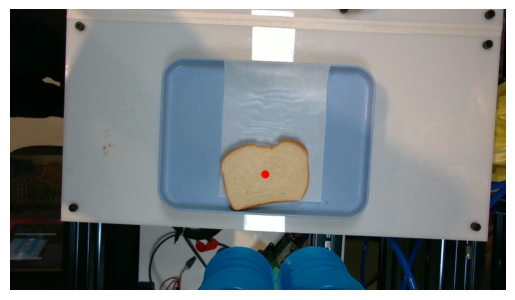

In [6]:
# Plot the plot image using matplotlib
plt.imshow(cv2.cvtColor(plot_image, cv2.COLOR_BGR2RGB))
plt.axis("off")  # Hide the axes
plt.show()

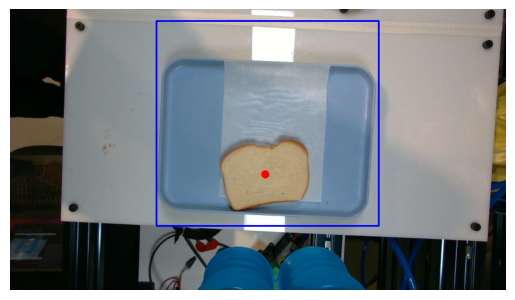

In [7]:
# Plot the bounding box correspoinding to the tray
plot_image = cv2.rectangle(
    plot_image,
    (TRAY_BOX_PIX[0], TRAY_BOX_PIX[1]),
    (TRAY_BOX_PIX[2], TRAY_BOX_PIX[3]),
    (255, 0, 0),
    2,
)
plt.imshow(cv2.cvtColor(plot_image, cv2.COLOR_BGR2RGB))
plt.axis("off")  # Hide the axes
plt.show()

In [8]:
input_img_dir = "/home/parth/snaak/snaak_data/bread_bottom_images2/"
output_img_dir = "/home/parth/snaak/snaak_data/results/"

if not os.path.exists(output_img_dir):
    os.makedirs(output_img_dir)

for img_name in os.listdir(input_img_dir):
    img = cv2.imread(os.path.join(input_img_dir, img_name))
    (x, y), plot_image = get_bread_top_placement_xy(None, img)
    cv2.imwrite(
        os.path.join(output_img_dir, img_name.replace(".png", "_result.png")),
        plot_image,
    )